# Checking all modules
## Get access to all modules

In [1]:
import sys                                                             
sys.path.insert(0, '..')

## Imports

In [2]:
# Build-in
import logging
from pathlib import Path
# ML
import torch
import numpy as np
# Visualization
import matplotlib.pyplot as plt
# Own
from helpers.utils import overview, Scaler
from helpers.viz import plot, plot_predictions, plot_history, init_plot
from helpers.metrics import calculate_metrics, MAE
from helpers.dtw import parallel_dtw, sequential_dtw

from models.estimator import Model as Estimator
from models.stgm import Model as STGM
from models.stgm_full import Model as STGM_FULL

from datasets.pemsbay import Dataset as PEMSBAY
from datasets.metrla import Dataset as METRLA
from datasets.pemsd7m import Dataset as PEMSD7M

from trainers.default import Trainer as DefaultTrainer
# from trainers.estimator import Trainer as EstimatorTrainer
from trainers.full import Trainer as FullTrainer

## Loading custom plotting style

This is a custom style not provided with the repo, if you have a costum matplotlib style registred provid it instead of `"paper"`

In [3]:
init_plot("paper")

## Dummy params

In [4]:
# Dataset params
BATCH_SIZE = 16
WINDOW_SIZE = 12
# Model params
IN_CHANNELS = 1
HIDDEN_CHANNELS = 32
BIAS = True
CHANNELS_LAST = True
# Trainer params
EPOCHS = 2
# Extra params
DEVICE = "cuda"

## Checking the datasets
### PEMS-BAY

In [5]:
dataset = PEMSBAY(batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
scaler = Scaler(*dataset.scaler_info)
timestamps, idx, adj, sim, x, y = dataset.get_sample(with_timestamps=True)
print(f"{timestamps.shape=}\n{idx.shape=}\n{adj.shape=}\n{sim.shape=}\n{x.shape=}\n{y.shape=}\n{dataset.node=}\n{dataset.degrees_max=}\n{dataset.degrees.shape=}")

No pre-calculated contribution matrix was provided ! You will experience Heavy CPU load and Slow data loading...


timestamps.shape=(12,)
idx.shape=torch.Size([1, 2, 12])
adj.shape=torch.Size([1, 325, 325])
sim.shape=torch.Size([1, 325, 325])
x.shape=torch.Size([1, 12, 325, 1])
y.shape=torch.Size([1, 12, 325, 1])
dataset.node=325
dataset.degrees_max=13
dataset.degrees.shape=(325,)


### METR-LA

In [6]:
dataset = METRLA(batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
scaler = Scaler(*dataset.scaler_info)
timestamps, idx, adj, sim, x, y = dataset.get_sample(with_timestamps=True)
print(f"{timestamps.shape=}\n{idx.shape=}\n{adj.shape=}\n{sim.shape=}\n{x.shape=}\n{y.shape=}\n{dataset.node=}\n{dataset.degrees_max=}\n{dataset.degrees.shape=}")

No pre-calculated contribution matrix was provided ! You will experience Heavy CPU load and Slow data loading...


timestamps.shape=(12,)
idx.shape=torch.Size([1, 2, 12])
adj.shape=torch.Size([1, 207, 207])
sim.shape=torch.Size([1, 207, 207])
x.shape=torch.Size([1, 12, 207, 1])
y.shape=torch.Size([1, 12, 207, 1])
dataset.node=207
dataset.degrees_max=11
dataset.degrees.shape=(207,)


### PEMSD7M

In [6]:
dataset = PEMSD7M(batch_size=BATCH_SIZE, window_size=WINDOW_SIZE)
scaler = Scaler(*dataset.scaler_info)
timestamps, idx, adj, sim, x, y = dataset.get_sample(with_timestamps=True)
print(f"{timestamps.shape=}\n{idx.shape=}\n{adj.shape=}\n{sim.shape=}\n{x.shape=}\n{y.shape=}\n{dataset.node=}\n{dataset.degrees_max=}\n{dataset.degrees.shape=}")

No pre-calculated contribution matrix was provided ! You will experience Heavy CPU load and Slow data loading...


timestamps.shape=(12,)
idx.shape=torch.Size([1, 2, 12])
adj.shape=torch.Size([1, 228, 228])
sim.shape=torch.Size([1, 228, 228])
x.shape=torch.Size([1, 12, 228, 1])
y.shape=torch.Size([1, 12, 228, 1])
dataset.node=228
dataset.degrees_max=226
dataset.degrees.shape=(228,)


## Checking the Models

We redeclare `EMBEDDING_DICT` since there is a bug and the model edit the outside variables when adding the supernode.

### Estimator

In [7]:
EMBEDDING_DICT = {
    "time": 24 * 7 * 12,
    "day": 7,
    "node": dataset.node,
    "degree": dataset.degrees_max
}

estimator = Estimator(
    in_channels=IN_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    embedding_dict=EMBEDDING_DICT,
    bias=BIAS,
    channels_last=CHANNELS_LAST,
    device=DEVICE,
)

with torch.no_grad():
    pred = estimator(
        x=scaler.norm(x.to(DEVICE)), 
        idx=idx.to(DEVICE)
    ).cpu()
pred.shape == adj.shape # Using adj to check instead of dtw since they have the same shape and dtw takes a long time to calculate

True

tensor(0.3722)


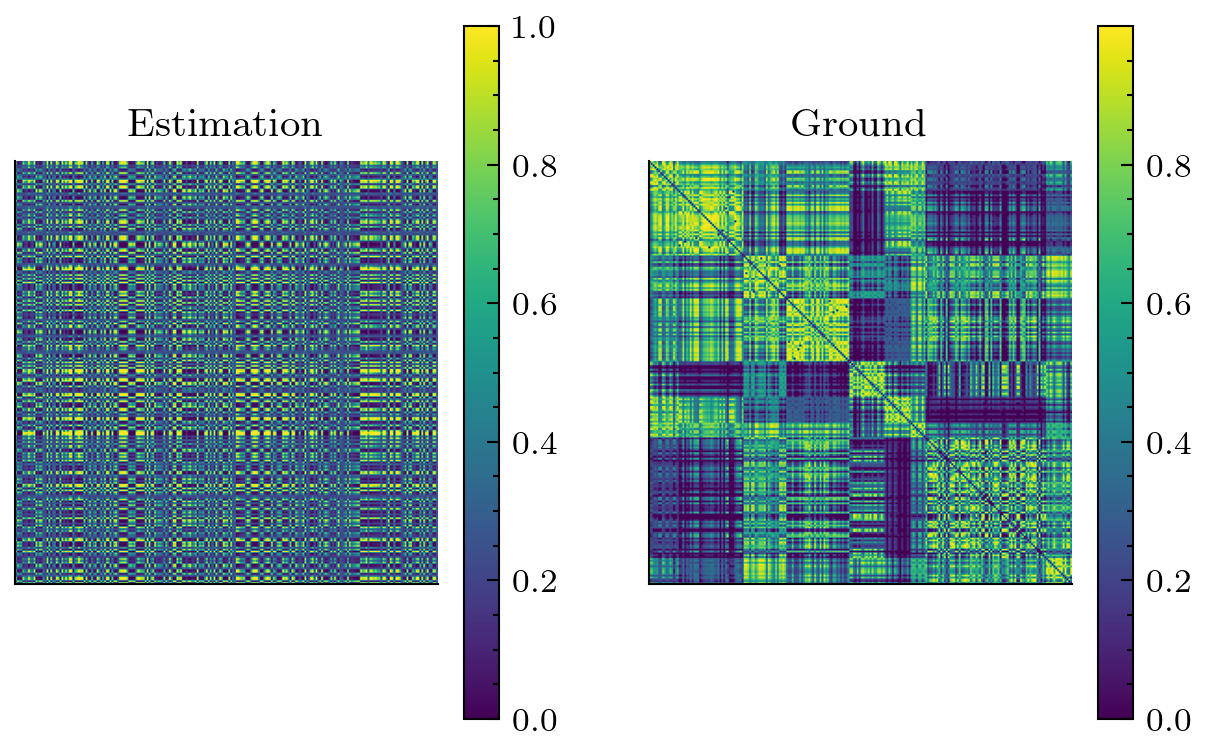

In [8]:
print(MAE(pred, sim, dim=(0, 1, 2)))
_, ax = plt.subplots(1, 2)
plt.colorbar(ax[0].imshow(pred.cpu()[0]))
ax[0].grid(False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Estimation")
plt.colorbar(ax[1].imshow(sim.cpu()[0]))
ax[1].grid(False)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Ground")
plt.show()

tensor(0.3722)


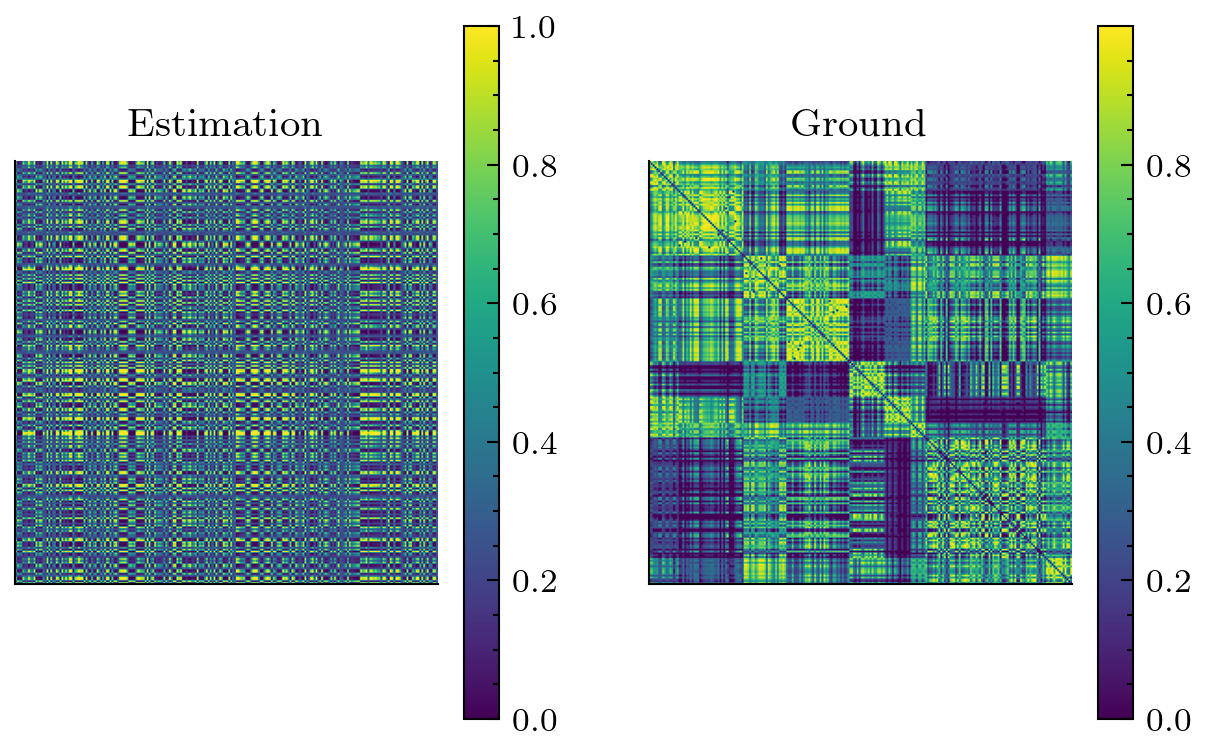

In [9]:
print(MAE(pred, adj, dim=(0, 1, 2)))
_, ax = plt.subplots(1, 2)
plt.colorbar(ax[0].imshow(pred.cpu()[0]))
ax[0].grid(False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Estimation")
plt.colorbar(ax[1].imshow(adj.cpu()[0])) # Compairing with the distance matrix
ax[1].grid(False)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Ground")
plt.show()

### STGM without estimator

In [10]:
EMBEDDING_DICT = {
    "time": 24 * 7 * 12,
    "day": 7,
    "node": dataset.node,
    "degree": dataset.degrees_max
}

stgm = STGM(
    in_channels=IN_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=IN_CHANNELS,
    timestep_max=WINDOW_SIZE,
    embedding_dict=EMBEDDING_DICT,
    nb_blocks=1,
    use_super_node=True,
    degrees=dataset.degrees,
    show_scores=False,
    channels_last=CHANNELS_LAST,
    device=DEVICE,
)

with torch.no_grad():
    pred = scaler.reverse(
        stgm(
            x=scaler.norm(x.to(DEVICE)), 
            adj=adj.to(DEVICE),
            idx=idx.to(DEVICE)
        ).cpu()
    )
pred.shape == y.shape

True


                                Mean Error Real                                 
--------------------------------------------------------------------------------
        MSE                 RMSE                MAE                 MAPE        
--------------------------------------------------------------------------------
       253.78              15.84               12.79               22.37%       
                               By Step Error Real                               
--------------------------------------------------------------------------------
     Steps            MSE             RMSE            MAE             MAPE      
--------------------------------------------------------------------------------
       1             365.41          19.12           16.40           24.29%     
       2             262.89          16.21           13.84           20.49%     
       3             325.23          18.03           15.04           22.32%     
       4             170.85

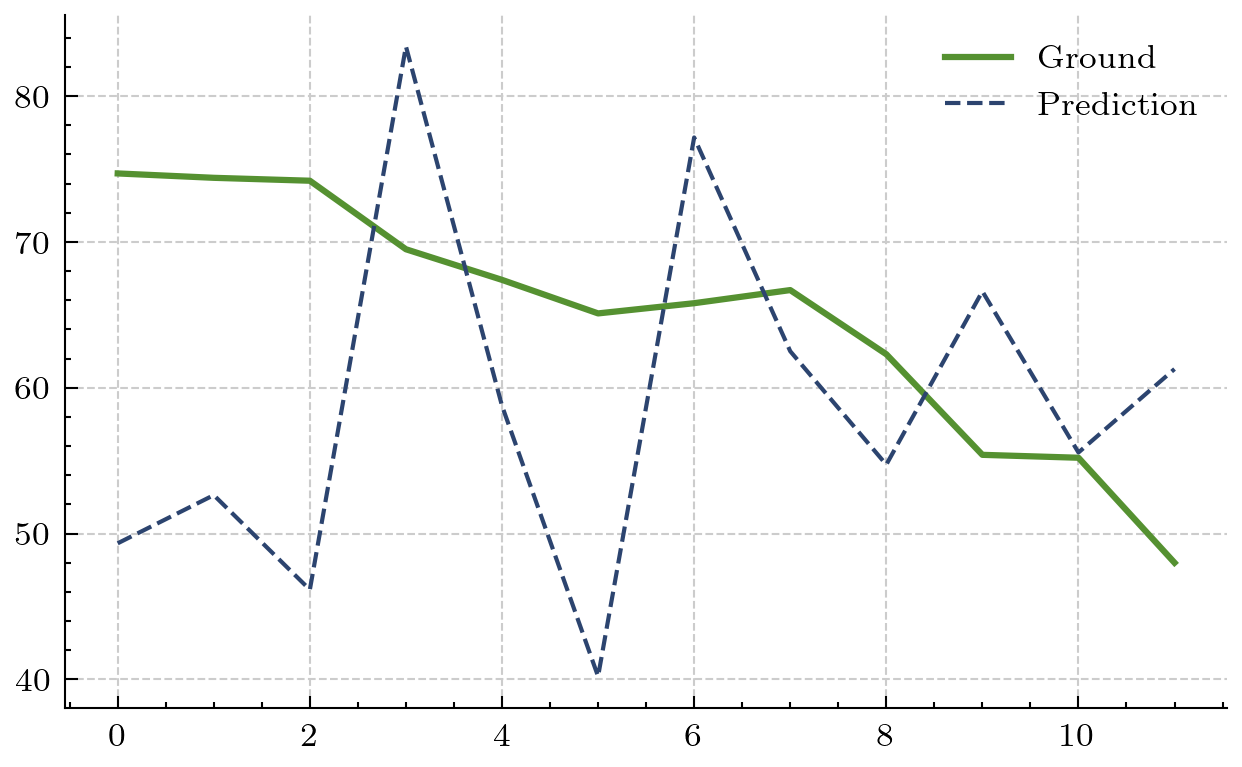

In [11]:
print(overview(pred, y, null_val=0))
plt.plot(y[0, :, 0, 0], "-", lw=1.5, label="Ground")
plt.plot(pred[0, :, 0, 0], "--", label="Prediction")
plt.legend()
plt.show()

### STGM with estimator

In [12]:
EMBEDDING_DICT = {
    "time": 24 * 7 * 12,
    "day": 7,
    "node": dataset.node,
    "degree": dataset.degrees_max
}

stgm_full = STGM_FULL(
    in_channels=IN_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    out_channels=IN_CHANNELS,
    timestep_max=WINDOW_SIZE,
    embedding_dict=EMBEDDING_DICT,
    nb_blocks=1,
    use_super_node=True,
    degrees=dataset.degrees,
    show_scores=False,
    channels_last=CHANNELS_LAST,
    device=DEVICE,
)

with torch.no_grad():
    pred = scaler.reverse(
        stgm_full(
            x=scaler.norm(x.to(DEVICE)), 
            adj=adj.to(DEVICE),
            adj_hat=sim.to(DEVICE),
            idx=idx.to(DEVICE)
        ).cpu()
    )
pred.shape == y.shape

True


                                Mean Error Real                                 
--------------------------------------------------------------------------------
        MSE                 RMSE                MAE                 MAPE        
--------------------------------------------------------------------------------
       240.97              15.35               12.43               21.63%       
                               By Step Error Real                               
--------------------------------------------------------------------------------
     Steps            MSE             RMSE            MAE             MAPE      
--------------------------------------------------------------------------------
       1             421.68          20.53           17.58           26.08%     
       2             156.09          12.49            9.86           14.59%     
       3             272.08          16.49           13.71           20.51%     
       4             161.12

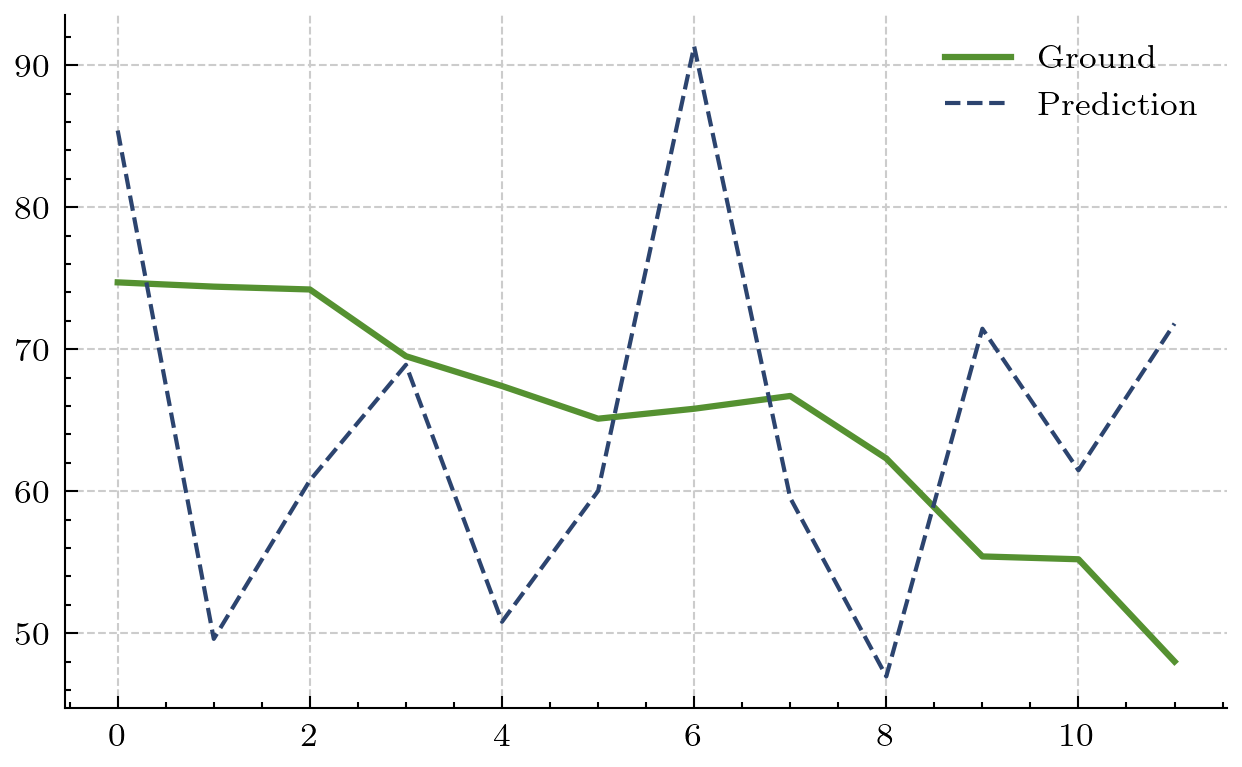

In [13]:
print(overview(pred, y, null_val=0))
plt.plot(y[0, :, 0, 0], "-", lw=1.5, label="Ground")
plt.plot(pred[0, :, 0, 0], "--", label="Prediction")
plt.legend()
plt.show()

## Checking viz utils

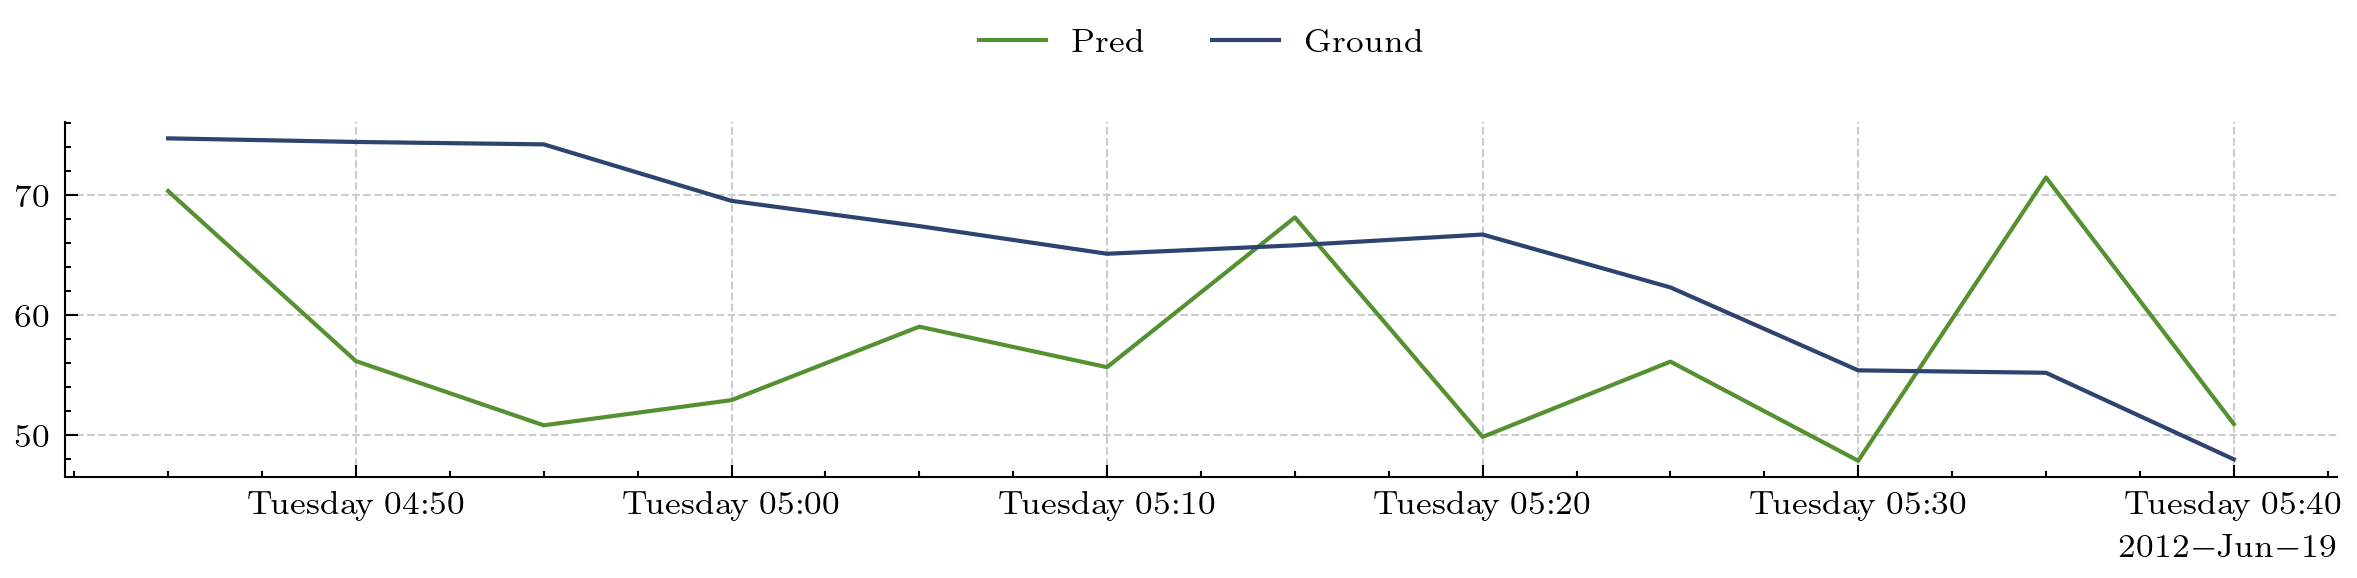

In [15]:
_ = plot(timestamps, (pred[0, :, 0, 0], y[0, :, 0, 0]), ("Pred", "Ground"))

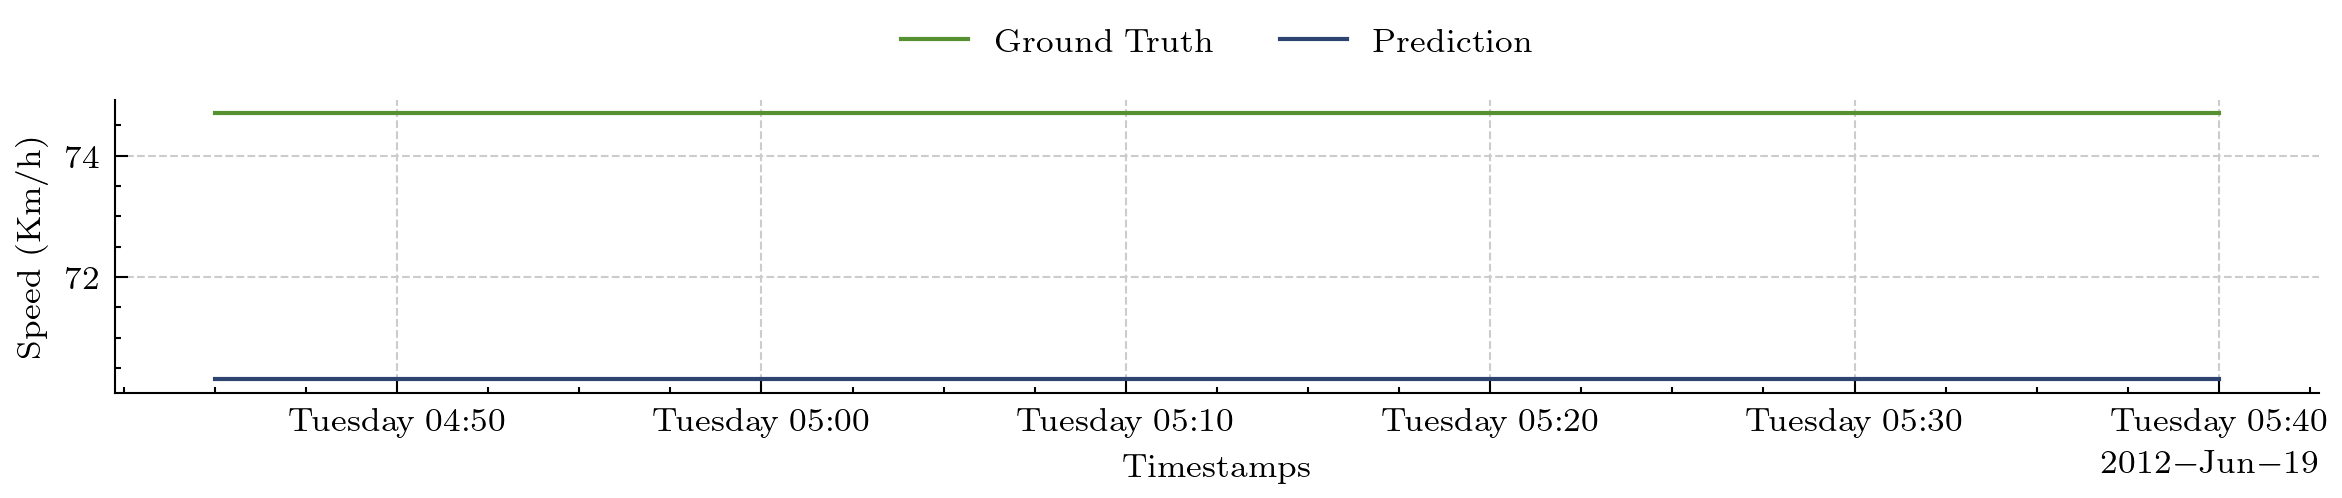

In [16]:
plot_predictions(pred.repeat(WINDOW_SIZE, 1, 1, 1), y.repeat(WINDOW_SIZE, 1, 1, 1), timestamps=timestamps)

## Checking DTW implementation
### Sequential

In [17]:
# %%timeit
dtw = dataset.normalize_sim(sequential_dtw(x[0, ..., 0].T.numpy(), y[0, ..., 0].T.numpy()))
dtw.shape

(228, 228)

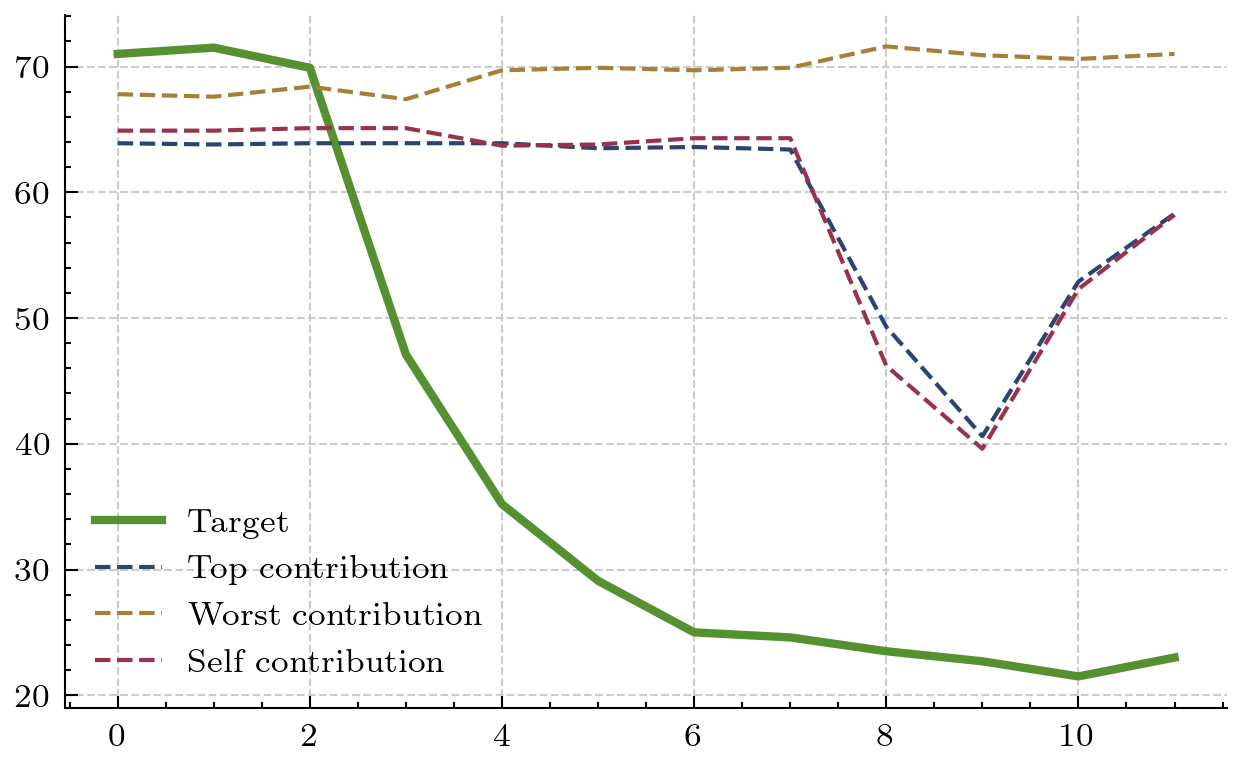

In [18]:
target_node = 57
ranking = dtw[:, target_node].argsort(0).reshape(-1)
plt.plot(y[0, :, target_node, 0], "-", lw=2, label="Target")
plt.plot(x[0, :, ranking[1], 0], "--", label="Top contribution")
plt.plot(x[0, :, ranking[-1], 0], "--", label="Worst contribution")
plt.plot(x[0, :, ranking[0], 0], "--", label="Self contribution")
plt.legend()
plt.show()

### Parallel

In [19]:
# %%timeit
dtw = dataset.normalize_sim(parallel_dtw(x[0, ..., 0].T.numpy(), y[0, ..., 0].T.numpy()))
dtw.shape

(228, 228)

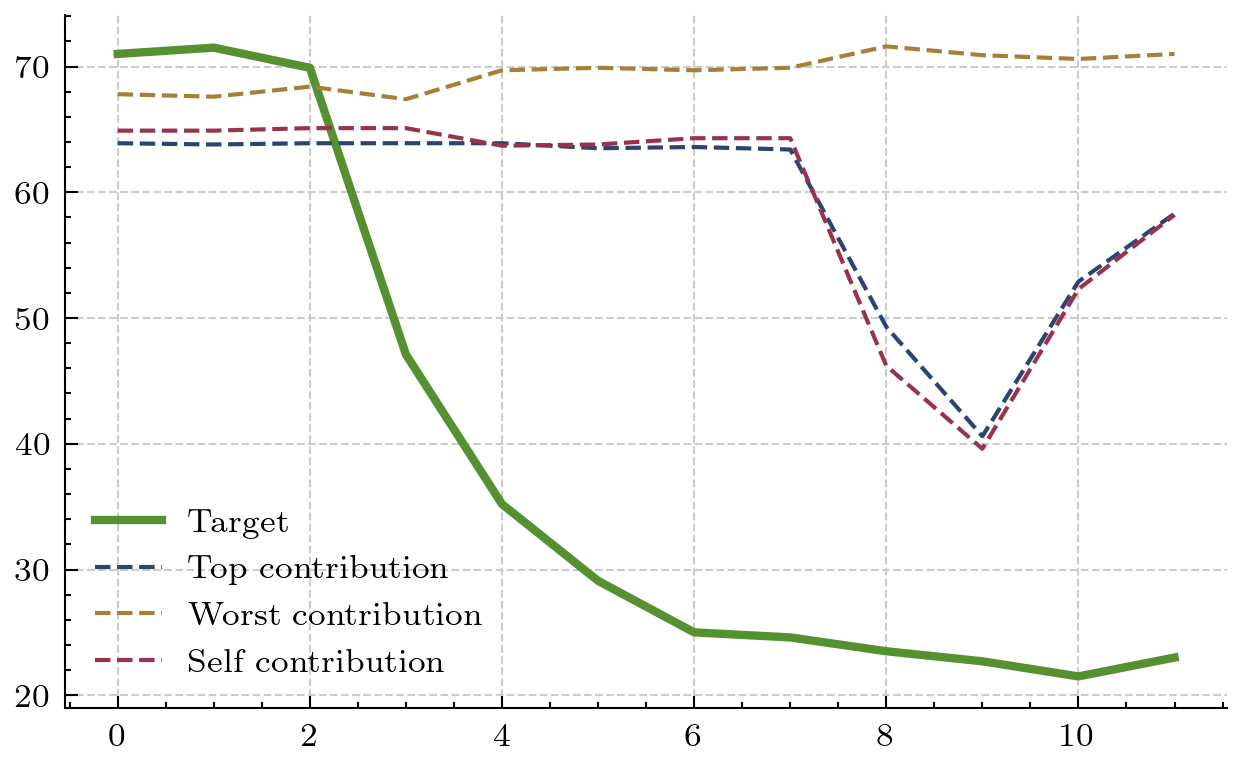

In [20]:
target_node = 57
ranking = dtw[:, target_node].argsort(0).reshape(-1)
plt.plot(y[0, :, target_node, 0], "-", lw=2, label="Target")
plt.plot(x[0, :, ranking[1], 0], "--", label="Top contribution")
plt.plot(x[0, :, ranking[-1], 0], "--", label="Worst contribution")
plt.plot(x[0, :, ranking[0], 0], "--", label="Self contribution")
plt.legend()
plt.show()

### Checking the DTW norm

In [21]:
dtw = parallel_dtw(x[0, ..., 0].T.numpy(), y[0, ..., 0].T.numpy())
dtw.shape

(228, 228)

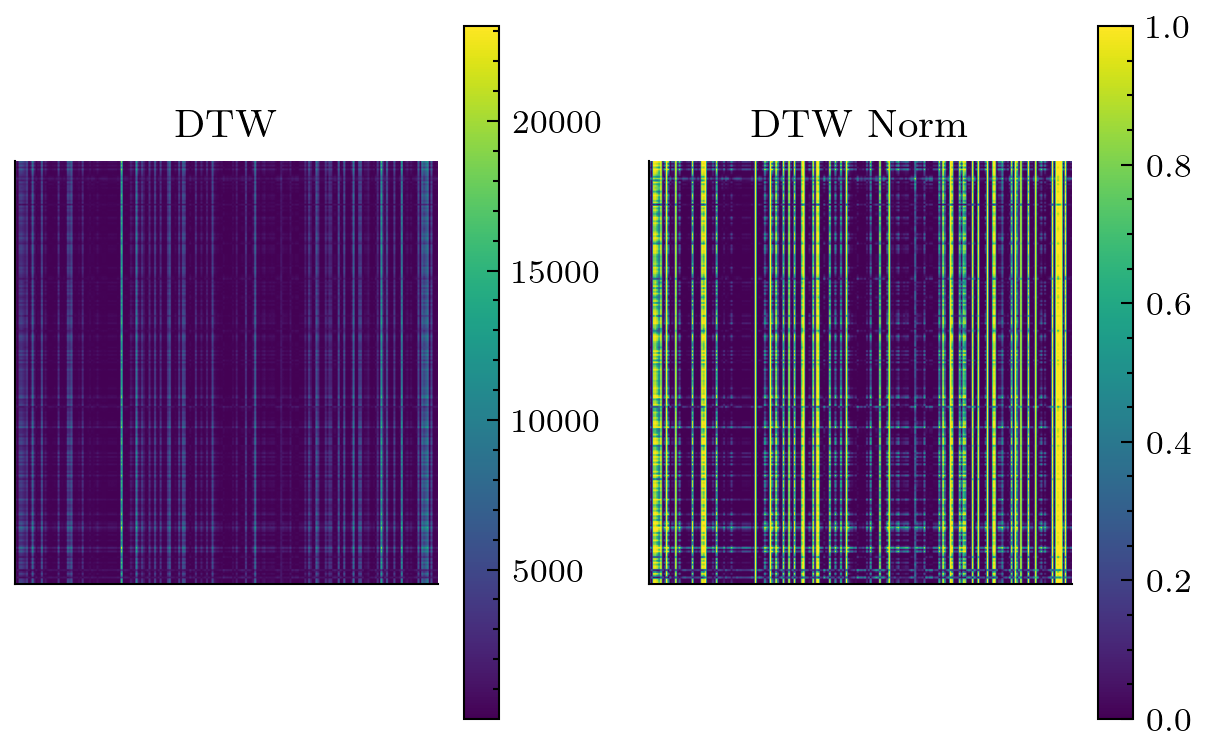

In [22]:
_, ax = plt.subplots(1, 2)
plt.colorbar(ax[0].imshow(dtw))
ax[0].grid(False)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("DTW")
plt.colorbar(ax[1].imshow(dataset.normalize_sim(dtw, 1)))
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("DTW Norm")
plt.show()

## Checking training

In [13]:
default_trainer = DefaultTrainer(
    model=stgm,
    scaler=scaler,
    epochs=EPOCHS,
    verbose=True,
    use_amp=False,
    device=DEVICE,
)

Epoch 2/2 train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:14<00:00,  7.09s/it, loss=47.4, loss_val=39.8]


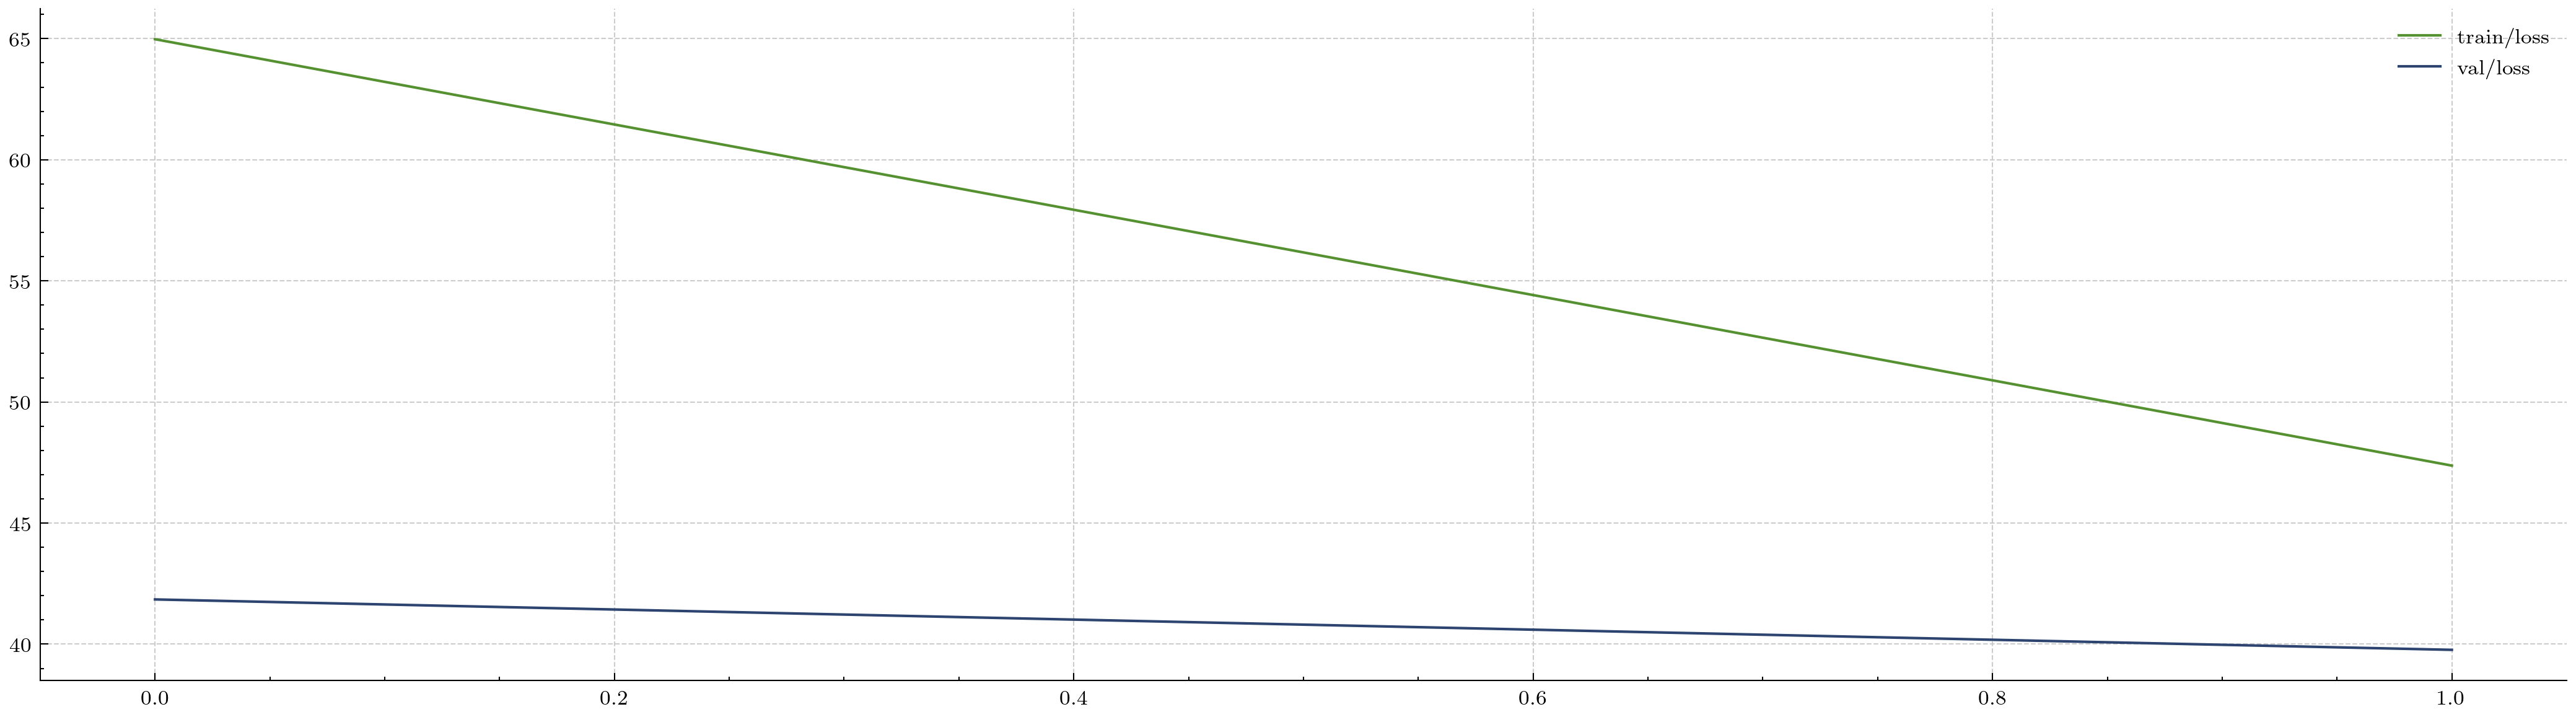

In [14]:
_ = plot_history(default_trainer(train_data=dataset.get_data_loader(), val_data=dataset.get_data_loader()))

In [14]:
default_trainer = FullTrainer(
    model=stgm_full,
    e_model=estimator,
    scaler=scaler,
    epochs=EPOCHS,
    verbose=True,
    use_amp=False,
    device=DEVICE,
)

Epoch 2/2 train: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:15<00:00,  7.67s/it, e_loss=0.00181, e_loss_val=1.62, loss=0.0474, loss_val=36.6]


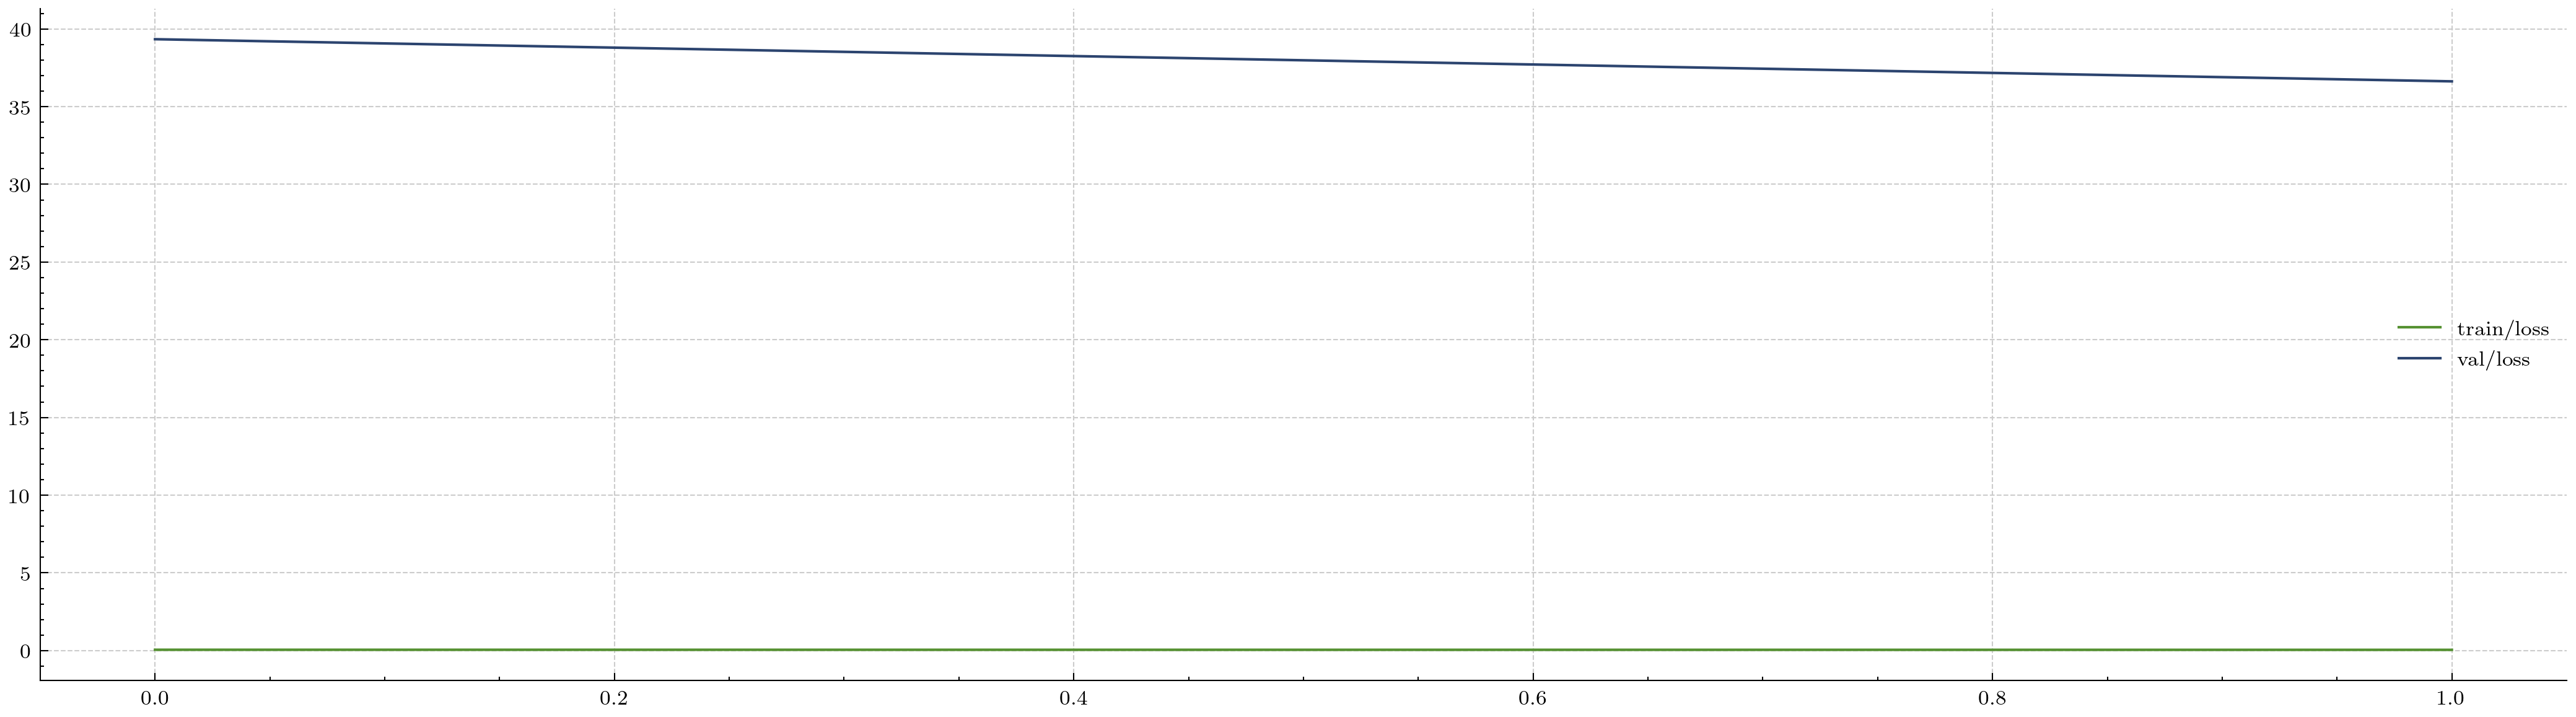

In [15]:
_ = plot_history(default_trainer(train_data=dataset.get_data_loader(), val_data=dataset.get_data_loader()))

In [16]:
preds = default_trainer.get_predictions(dataset.get_data_loader())

Generating predictions: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 67.83it/s]


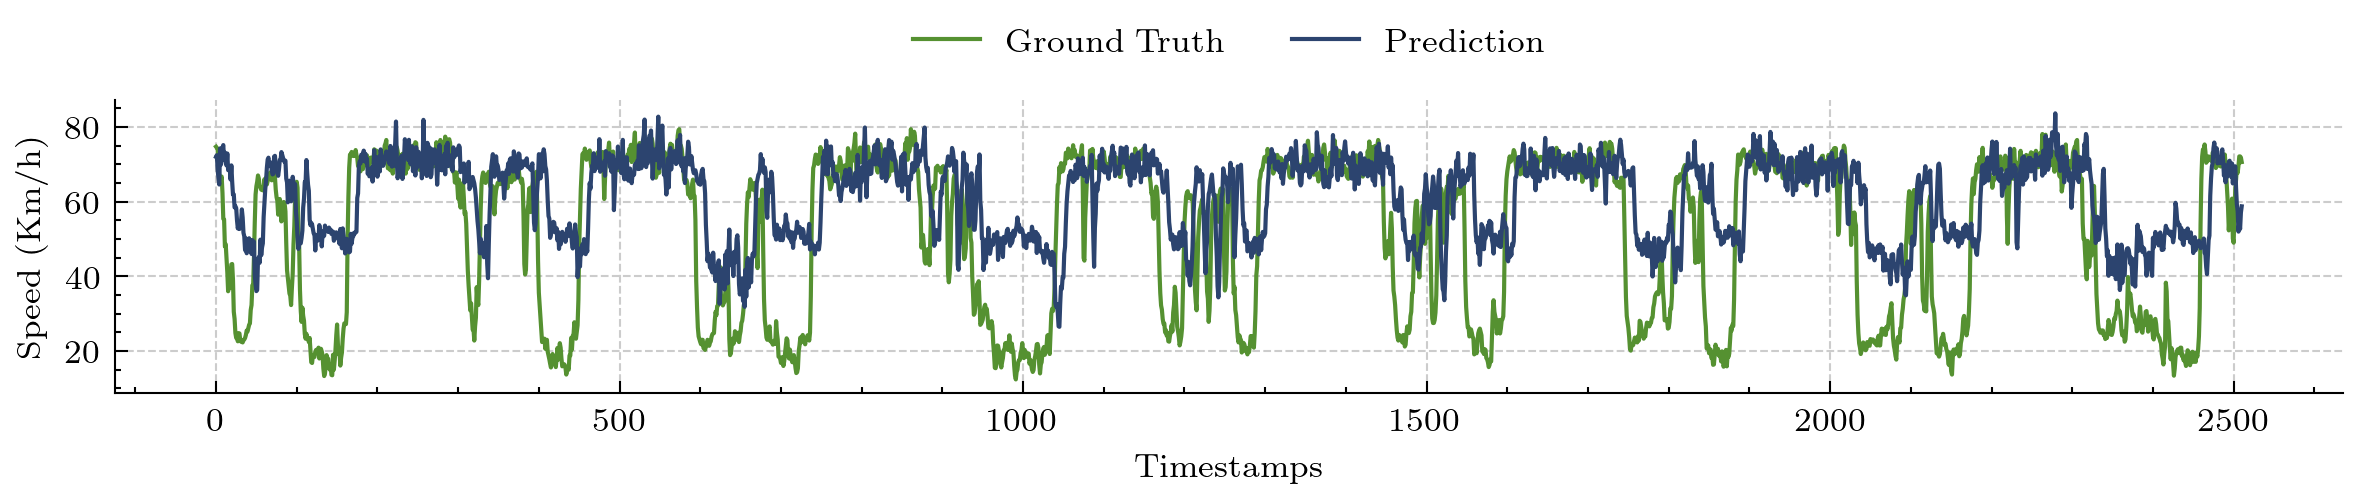


                                Mean Error Real                                 
--------------------------------------------------------------------------------
        MSE                 RMSE                MAE                 MAPE        
--------------------------------------------------------------------------------
       140.85              11.86                8.36               23.10%       
                               By Step Error Real                               
--------------------------------------------------------------------------------
     Steps            MSE             RMSE            MAE             MAPE      
--------------------------------------------------------------------------------
       1             161.66          12.71            8.25           24.56%     
       2             144.98          12.04            8.30           23.45%     
       3             142.98          11.96            8.17           23.30%     
       4             142.79

In [22]:
plot_predictions(*preds)
print(overview(*preds, null_val=0))